In [158]:
# sourse cell
import re
import pandas as pd
import pickle
pd.set_option('display.max_colwidth', 100)

model_name = 'ArcFace'
path_to_original = '0_ORIGINAL_PNG_250_200\\0_ORIGINAL_PNG_250_200\\'

with open(path_to_original + 'representations_arcface.pkl', "rb") as f:
    otiginal_descriptors = pickle.load(f)
df = pd.DataFrame(otiginal_descriptors, columns = ["identity", "%s_representation" % (model_name)])

df_base = df.copy()

# display
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import cv2

def drawImage(img):
    display(Image.fromarray(img))

def get_file_name(path):
    return re.split('\\\|\.|\/', path)[-2]

def toGray(img_cv2):
    return cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)

def toBGR(img_cv2):
    return cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

def img_to_bytes(img):
    return cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1].tobytes()

def quality(df):
    return 100 * sum(map(int, df['res'])) / df.shape[0]
    

In [100]:
# sourse cell
#path_to_original = '0_ORIGINAL_PNG_250_200\\0_ORIGINAL_PNG_250_200\\'
path_to_white = '1_White_Masks\\1_White_Masks\\'
path_to_black = '4_Black_Masks\\'
path_to_red = '20 RED\\20 RED\\'
path_to_blue_black = 'DATA_5 (Blue-black)\\DATA_5 (Blue-black)\\'
path_to_res = 'DATA_RES_1\\DATA_RES_1\\'

path_to_fisheye_6 = 'FishEye_Fawkes_100\\DATA_6 (FishEye)\\'
path_to_fisheye_7 = 'FishEye_Fawkes_100\\DATA_7 (FishEye)\\'
path_to_fawkes_8 = 'FishEye_Fawkes_100\\DATA_8 (Fawkes)\\'

path_to_2a_mirror = 'Mirror_BGR_100\\DATA_2a_Mirror\\'
path_to_2b_BGR = 'Mirror_BGR_100\\DATA_2b_BGR\\'

path_to_red_gray_black_2 = 'Red_Gray_Black_100\\DATA_2\\'
path_to_red_gray_black_3 = 'Red_Gray_Black_100\\DATA_3\\'
path_to_red_gray_black_4 = 'Red_Gray_Black_100\\DATA_4\\'

In [64]:
# my find
from deepface.basemodels import ArcFace
from deepface.commons import functions, distance as dst
import pandas as pd
import pickle
import os

def find(test_db_path, df_base, detector_backend = 'retinaface', model_name = 'ArcFace', metric_name = 'cosine'):

    get = '%s_%s' % (model_name, metric_name)

    file_name = "res_data_%s.pkl" % (model_name)
    full_path = test_db_path + file_name
    if os.path.exists(full_path):
        with open(full_path, "rb") as f:
            output = pickle.load(f)
    
    else: #create res from scratch
        model = ArcFace.loadModel()

        #decide input shape
        input_shape_x, input_shape_y = functions.find_input_shape(model)

        df = df_base.copy()
        resp_obj = []
        indexs = []
        for r, d, f in os.walk(test_db_path): # r=root, d=directories, f = files
            for file in f:
                if ('.png' in file):
                    exact_path = r + file
                    indexs.append(exact_path)
                    detected_face, face_region = functions.preprocess_face(img = exact_path
                        , target_size = (input_shape_y, input_shape_x)
                        , detector_backend = detector_backend
                        , return_region = True)
                    face_representation = model.predict(detected_face)[0].tolist()

                    distances = []
                    for index, instance in df.iterrows():
                        source_representation = instance['%s_representation' % (model_name)]
                        distance = dst.findCosineDistance(source_representation, face_representation)
                        distances.append(distance)
                    df[get] = distances
                    df = df.drop(columns = ['%s_representation' % (model_name)])
                    df = df.sort_values(by = [get], ascending=True).reset_index(drop=True)
                    res = True
                    if int(get_file_name(file)) != int(get_file_name(df['identity'][0])):
                        res = False
                    resp_obj.append([res, face_region, df])
                    df = df_base.copy() #restore df for the next iteration
        output = pd.DataFrame(resp_obj, index = indexs, columns = ['res','area', 'data'])
        with open(full_path, "wb") as f:
            pickle.dump(output, f)
    return output


In [241]:
#visualize
from deepface.commons import functions
import cv2
import ipywidgets as widgets
import pandas as pd
import pickle

def visualize(test_db_path, qshow = 3, detector_backend = 'retinaface', model_name = 'ArcFace', metric_name = 'cosine'):

    get = '%s_%s' % (model_name, metric_name)

    file_name = "res_data_%s.pkl" % (model_name)
    full_path = test_db_path + file_name
    if os.path.exists(full_path):
        with open(full_path, "rb") as f:
            df_test = pickle.load(f)
    

    dim, _ = df_test.shape

    labelin = widgets.Label(value='Input')
    labelres = widgets.Label(value='    TRUE')
    labelout = widgets.Label(value='Output')
    labelpercent = widgets.Label(value = f'RES : {quality(df_test)} %')

    slider = widgets.IntSlider(description ='Face', value = 2, max = dim, min = 1)
    
    disp_face = widgets.Image()
    disp_face_rec = widgets.Image()
    #disp_face_extract = widgets.Image()
    grid1 = widgets.GridspecLayout(1, qshow)
    grid2 = widgets.GridspecLayout(1, qshow)
    for j in range(qshow):
        grid1[0, j] = widgets.Label(value='d :')
        grid2[0, j] = widgets.Image()
    
    def update(change):
        if change['type'] == 'change' and change['name'] == 'value':
            series = df_test.iloc[slider.value - 1]
            flag, rec, df_info = series
            face_path = series.name
            x, y, w, h = rec
            
            face_rec = toBGR(functions.load_image(face_path))
            cv2.rectangle(face_rec, rec, (0, 255, 0), 5)
            labelres.value = '    FALSE'
            if flag:
                labelres.value = '    TRUE'
            disp_face.set_value_from_file(face_path)
            disp_face_rec.value = img_to_bytes(face_rec)
            #disp_face_extract.value = img_to_bytes(face[y : y + h, x : x + w])
            for j in range(qshow):
                grid1[0, j].value = f'{metric_name}: {df_info[get][j]}'
                grid2[0, j].set_value_from_file(df_info['identity'][j])

    slider.observe(update, names='value')
    display(widgets.VBox([slider, labelin, widgets.HBox([disp_face, disp_face_rec, labelres]), labelout, grid1, grid2, labelpercent]))
    slider.value = 1

In [157]:
find(path_to_white, df_base);
find(path_to_black, df_base);
find(path_to_red, df_base);
find(path_to_blue_black, df_base);
find(path_to_res, df_base);

find(path_to_fisheye_6, df_base);
find(path_to_fisheye_7, df_base);
find(path_to_fawkes_8, df_base);

find(path_to_2a_mirror, df_base);
find(path_to_2b_BGR, df_base);

find(path_to_red_gray_black_2, df_base);
find(path_to_red_gray_black_3, df_base);
find(path_to_red_gray_black_4, df_base);


In [242]:
visualize(path_to_red_gray_black_3, 5)


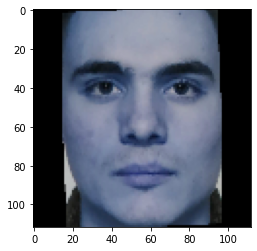

In [134]:
# самостоятельная обработка 

from deepface.detectors import FaceDetector
from deepface.commons import functions
from tensorflow.keras.preprocessing import image

import numpy as np
import cv2

model = ArcFace.loadModel()
#decide input shape
input_shape_x, input_shape_y = functions.find_input_shape(model)



nik_path = 'nik.png'
img = functions.load_image(nik_path)
detector_backend = 'retinaface'

face_detector = FaceDetector.build_model(detector_backend)

try:
	detected_face, img_region = FaceDetector.detect_face(face_detector, detector_backend, img, align = True)
except: #if detected face shape is (0, 0) and alignment cannot be performed, this block will be run
	detected_face = None

target_size=(input_shape_y, input_shape_x)

factor_0 = target_size[0] / detected_face.shape[0]
factor_1 = target_size[1] / detected_face.shape[1]
factor = min(factor_0, factor_1)

dsize = (int(detected_face.shape[1] * factor), int(detected_face.shape[0] * factor))
detected_face = cv2.resize(detected_face, dsize)

# Then pad the other side to the target size by adding black pixels
diff_0 = target_size[0] - detected_face.shape[0]
diff_1 = target_size[1] - detected_face.shape[1]

detected_face = np.pad(detected_face, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')

img_pixels = image.img_to_array(detected_face) #what this line doing? must?
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels /= 255 #normalize input in [0, 1]

plt.imshow(img_pixels[0][:,:,::1])


In [199]:
widgets.Dropdown(
    options=paths,
    description='Path to db:',
)

Dropdown(description='Path to db:', options=('1_White_Masks\\1_White_Masks\\', '4_Black_Masks\\', '20 RED\\20 …

In [227]:
dropdown = widgets.Dropdown(
    options=paths,
    value = '4_Black_Masks\\',
    description='Path to db:',
)
text = widgets.Image()

model_name = 'ArcFace'
def change_path(change):
    file_name = "res_data_%s.pkl" % (model_name)
    full_path = change.new + file_name
    
    print('true')
    f = open(full_path, "rb")
    output = pickle.load(f)
    f.close()
    text.set_value_from_file(output.iloc[0].name)
dropdown.observe(change_path, names='value')

display( widgets.VBox([dropdown, text]) )
dropdown.value ='1_White_Masks\\1_White_Masks\\'


true


In [197]:
paths = ['1_White_Masks\\1_White_Masks\\',
'4_Black_Masks\\',
'20 RED\\20 RED\\',
'DATA_5 (Blue-black)\\DATA_5 (Blue-black)\\',
'DATA_RES_1\\DATA_RES_1\\',

'FishEye_Fawkes_100\\DATA_6 (FishEye)\\',
'FishEye_Fawkes_100\\DATA_7 (FishEye)\\',
'FishEye_Fawkes_100\\DATA_8 (Fawkes)\\',
'Mirror_BGR_100\\DATA_2a_Mirror\\',
'Mirror_BGR_100\\DATA_2b_BGR\\',
'Red_Gray_Black_100\\DATA_2\\',
'Red_Gray_Black_100\\DATA_3\\',
'Red_Gray_Black_100\\DATA_4\\']

In [192]:
#res to csv
from datetime import datetime
now = datetime.now()


outdf = pd.DataFrame()
outdf['paths'] = paths
odj = list(map(lambda s: find(s, df_base), paths))
outdf['quantity'] = list(map(len, odj))
outdf['result'] = list(map(quality, odj))
outdf.to_excel(f'results_{now.strftime("%m.%d.%Y")}.xlsx')  
outdf

,paths,quantity,result
0,1_White_Masks\1_White_Masks\,100,90.000000
1,4_Black_Masks\,20,100.000000
2,20 RED\20 RED\,20,90.000000
3,DATA_5 (Blue-black)\DATA_5 (Blue-black)\,100,94.000000
4,DATA_RES_1\DATA_RES_1\,100,48.000000
5,FishEye_Fawkes_100\DATA_6 (FishEye)\,99,30.303030
6,FishEye_Fawkes_100\DATA_7 (FishEye)\,99,31.313131
7,FishEye_Fawkes_100\DATA_8 (Fawkes)\,99,94.949495
8,Mirror_BGR_100\DATA_2a_Mirror\,99,68.686869
9,Mirror_BGR_100\DATA_2b_BGR\,100,86.000000
